<a href="https://colab.research.google.com/github/teddiclax/METHANE__PYROLYSIS__H2/blob/teddiclax/__METHANE__PYROLYSIS__H2__UPDATED__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### DATA PREPARATION ###
## Importing Necessary Libraries ##
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import time


## Loading Original Dataset ##
raw_df = pd.read_csv('/content/METHANE__PYROLYSIS__DATA .csv')
raw_df.columns = [col.strip() for col in raw_df.columns]

## Defining the Input Variables ##
feature_cols = ['T(C)', 'P(bar)', 'F(mL/h)', 'Y(%)', 'p(W)', 'TOS(h)']

## efining the Feature and Target Columns in the Raw Dataset ##
target_col = 'MoH(g)'

## Defining the Feature and Target Columns in the Raw Dataset ##
X_raw = raw_df[feature_cols].values
y_raw = raw_df[[target_col]].values  # The Shape of the Column (MoE) is (N,1)


## Generating Augmented Data for Training the Neural Networks ##
np.random.seed(42)
N_aug = 2 # The Original Raw Dataset is Multiplied by 100 (X 100)
X_aug = np.repeat(X_raw, N_aug, axis=0)
y_aug = np.repeat(y_raw, N_aug, axis=0)

## Adding of Noise to the Populated Raw Data ##
noise_level = 0.02
X_aug = X_aug * (1 + np.random.randn(*X_aug.shape) * noise_level)
y_aug = y_aug * (1 + np.random.randn(*y_aug.shape) * noise_level)

## Deploying the Logarithm Fucntion to the Target Variable (MoEE) for values MoH < 1 (target = log(MoH + 1)) ##
y_aug_log = np.log1p(y_aug)
y_raw_log = np.log1p(y_raw)

## Deploy a Sanity Check for no NaNs or formation of Negatives ##
print("Sanity check — any NaNs in y_aug_log?", np.isnan(y_aug_log).sum())

## Splitting the Dataset in the ratio of 70:15:15 for the Training, Validation and Test Sets ##

## It is worth noting that the Validation and Testing dataset is still unchanged   ##
X_train_aug, X_val_raw, y_train_log, y_val_log = train_test_split(
    X_aug, y_aug_log, test_size=0.2, random_state=42)

## Final Test Datasets with no Noise ##
X_test_raw = X_raw
y_test_log = y_raw_log

## Standardization of the Argumented Training Dataset ##
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

## Displaying the Shape of the Training, Validation and Testing  ##
print(f"\nTrain shape: {X_train_scaled.shape}, Val shape: {X_val_scaled.shape}, Test shape: {X_test_scaled.shape}")

Sanity check — any NaNs in y_aug_log? 0

Train shape: (286, 6), Val shape: (72, 6), Test shape: (179, 6)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
### PRELIMINARY DATA ANALYSIS OF THE RAW DATASET ###

## Filtering Operating Data with MoH(g) > 0 and NAN from MoH(g) > 0 ##

df_operational = raw_df[(raw_df['MoH(g)'] > 0) & raw_df['SEC(kWh/kg H2)'].notna()].copy()

## Carry Out Descriptive on the Raw Dataset (SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)')  ##

print("### 1. Descriptive Statistics of Derived Variables:\n ###")
desc_stats = df_operational[['SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)']].describe()
print(desc_stats)
print("\n")

## Carry Out Correlation Analysis on the Raw Dataset for both Input and Output dataset:'p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)','SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)'  ##
correlation_cols = ['p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)', 'SEC(kWh/kg H2)', 'EI(MJ/L H2)', 'VoH(L)', 'MoH(g)']
correlation_matrix = df_operational.dropna(subset=correlation_cols)[correlation_cols].corr(numeric_only=True)
print("### 2. Correlation Matrix of Key Parameters:\n ###")
print(correlation_matrix)
print("\n")

## Carry Out Binned Analysis of SEC by Magnetic Flux (B(mT)) ##
bins = [0, 10, 20, 30, 40, 50, 60]
labels = ['0-10mT', '11-20mT', '21-30mT', '31-40mT', '41-50mT', '51-60mT']
df_operational['B_Bin'] = pd.cut(df_operational['B(mT)'], bins=bins, labels=labels, right=True, include_lowest=True)
binned_sec_analysis = df_operational.groupby('B_Bin')['SEC(kWh/kg H2)'].agg(['mean', 'median', 'min', 'max', 'count'])
print("### 3. Binned Analysis of SEC by Magnetic Flux (B(mT)):\n ###")
print(binned_sec_analysis)
print("\n")


### Identifying the Most Energy-Efficient (Lowest SEC) ROW in the Raw Dataset ###
if not df_operational.empty:
    optimal_row_sec = df_operational.loc[(df_operational['SEC(kWh/kg H2)'].idxmin())]
    print("### 4. Most Energy-Efficient Operating Point (Lowest SEC):\n ###")
    print("The row representing the most energy-efficient operating point (lowest SEC) is:\n")
    print(optimal_row_sec[['p(W)', 'B(mT)', 'F(mL/h)', 'X(%)', 'TOS(h)', 'MoH(g)', 'VoH(L)', 'SEC(kWh/kg H2)', 'EI(MJ/L H2)']].to_markdown(index=True))
else:
    print("No operational data available (no MoH(g) > 0 or SEC is NaN). Cannot identify optimal point.")
print("\n")

### 1. Descriptive Statistics of Derived Variables:
 ###
       SEC(kWh/kg H2)  EI(MJ/L H2)      VoH(L)      MoH(g)
count      179.000000   179.000000  179.000000  179.000000
mean      8000.807484     2.606933   24.771715    2.242073
std      10118.108344     3.296821   58.309660    5.277571
min        658.241180     0.214477    0.063727    0.005768
25%       2462.075181     0.802227    1.212017    0.109699
50%       4628.258294     1.508043    4.923600    0.445632
75%       8995.962787     2.931189   14.407125    1.303980
max      80455.579720    26.215146  419.625000   37.980000


### 2. Correlation Matrix of Key Parameters:
 ###
                    p(W)     B(mT)   F(mL/h)      X(%)    TOS(h)  \
p(W)            1.000000 -0.108309  0.561669 -0.058791  0.483228   
B(mT)          -0.108309  1.000000 -0.181297  0.021182 -0.094980   
F(mL/h)         0.561669 -0.181297  1.000000  0.014420  0.499816   
X(%)           -0.058791  0.021182  0.014420  1.000000 -0.144728   
TOS(h)          0.48

/tmp/ipython-input-2753687158.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_sec_analysis = df_operational.groupby('B_Bin')['SEC(kWh/kg H2)'].agg(['mean', 'median', 'min', 'max', 'count'])


In [3]:
###  FULL MODELLING BLOCK FOR THE FEEDFORWARD NEURAL NETWORK (FNN) ###

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Defining the FNN Model ##
class FNN(nn.Module):
    def __init__(self, input_dim=6, hidden_dims=[256, 128, 64], activation='ReLU'):
        super(FNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]), act_fn(),
            nn.Linear(hidden_dims[0], hidden_dims[1]), act_fn(),
            nn.Linear(hidden_dims[1], hidden_dims[2]), act_fn(),
            nn.Linear(hidden_dims[2], 1)
        )

    def forward(self, x):
        return self.net(x)

## Preparing the Scaled Dataset for training the FNN ##
batch_size = 64
train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                         torch.tensor(y_train_log, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                       torch.tensor(y_val_log, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test_log, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Defining the Training Function as well as tracking the losses ##
def train_fnn(model, train_loader, val_loader, n_epochs=1000, lr=1e-3, patience=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_model_state = None
    best_val_loss = float('inf')
    wait = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).view(-1, 1)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        ## Validating the Trained FNN ##
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).view(-1, 1)
                epoch_val_loss += criterion(y_pred, yb).item()
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        if epoch % 10 == 0:
            print(f"FNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

## Training the FNN accross all Activation Functions ##
activations = ['ReLU', 'Tanh', 'GELU']
fnn_results = {}
fnn_train_losses = {} # Initialize the dictionary here
fnn_val_losses = {}   # Initialize the dictionary here

for activation in activations:
    print(f"\n FNN({activation})")
    fnn_model = FNN(input_dim=6, hidden_dims=[256, 128, 64], activation=activation)
    start_time = time.time()
    fnn_model, train_losses, val_losses = train_fnn(fnn_model, train_loader, val_loader)
    train_time = time.time() - start_time

    # Store the training and validation losses in the dictionaries
    fnn_train_losses[activation] = train_losses
    fnn_val_losses[activation] = val_losses

    ## Initiate Testing ##
    fnn_model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = fnn_model(xb).view(-1, 1)
            all_preds.append(pred.numpy())
            all_targets.append(yb.numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    y_true = np.expm1(all_targets)
    y_pred = np.expm1(all_preds)

    ## Store Results ##
    fnn_results[activation] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'train_time': train_time,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

    print(f"MAE={fnn_results[activation]['mae']:.4f}, "
          f"MSE={fnn_results[activation]['mse']:.4f}, "
          f"R2={fnn_results[activation]['r2']:.4f}")

    print(f"\nFirst 30 MoH Predictions (FNN - {activation}):")
    for i in range(min(30, len(y_true))):
        print(f"True: {y_true[i,0]:.3f}  Pred: {y_pred[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Storing the Predictions as well as Raw dataset based on the ReLU Activation Function ##
fnn_preds = fnn_results['ReLU']['y_pred']
y_test_raw = fnn_results['ReLU']['y_true'] # Make sure this is consistent with other cells if needed


 FNN(ReLU)
FNN Epoch 0: Val Loss = 0.5696
FNN Epoch 10: Val Loss = 0.0358
FNN Epoch 20: Val Loss = 0.0189
FNN Epoch 30: Val Loss = 0.0127
FNN Epoch 40: Val Loss = 0.0094
FNN Epoch 50: Val Loss = 0.0076
FNN Epoch 60: Val Loss = 0.0062
FNN Epoch 70: Val Loss = 0.0071
FNN Epoch 80: Val Loss = 0.0058
FNN Epoch 90: Val Loss = 0.0082
FNN Epoch 100: Val Loss = 0.0076
FNN Epoch 110: Val Loss = 0.0069
FNN Epoch 120: Val Loss = 0.0103
FNN Epoch 130: Val Loss = 0.0078
FNN Epoch 140: Val Loss = 0.0073
FNN Epoch 150: Val Loss = 0.0074
FNN Epoch 160: Val Loss = 0.0079
FNN Epoch 170: Val Loss = 0.0062
FNN Epoch 180: Val Loss = 0.0067
FNN Epoch 190: Val Loss = 0.0075
FNN Epoch 200: Val Loss = 0.0077
FNN Epoch 210: Val Loss = 0.0082
FNN Epoch 220: Val Loss = 0.0081
FNN Epoch 230: Val Loss = 0.0064
FNN Epoch 240: Val Loss = 0.0074
FNN Epoch 250: Val Loss = 0.0102
FNN Epoch 260: Val Loss = 0.0077
FNN Epoch 270: Val Loss = 0.0088
FNN Epoch 280: Val Loss = 0.0075
FNN Epoch 290: Val Loss = 0.0074
Early sto

In [4]:
###  FULL MODELLING BLOCK FOR THE BAYESIAN NEURAL NETWORK (BNN) ###

import torch.nn.functional as F

## Restoring the y_test from the previous test_loader  ##
y_test_log = test_loader.dataset.tensors[1].cpu().numpy()
y_test_raw = np.expm1(y_test_log)

## Defining the BNN Model with Monte Carlo Dropout ##
class BNN(nn.Module):
    def __init__(self, input_dim=6, hidden_dims=[256, 128, 64], dropout=0.1, activation='ReLU'):
        super(BNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.act1 = act_fn()
        self.do1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.act2 = act_fn()
        self.do2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.act3 = act_fn()
        self.do3 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(hidden_dims[2], 1)

    def forward(self, x):
        x = self.do1(self.act1(self.fc1(x)))
        x = self.do2(self.act2(self.fc2(x)))
        x = self.do3(self.act3(self.fc3(x)))
        x = self.fc4(x)
        return x

## Defining the Training Function as well as tracking the Losses ##
def train_bnn(model, train_loader, val_loader, n_epochs=1000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model_state = None
    best_val_loss = float('inf')
    patience = 100
    wait = 0

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).squeeze(1)
            yb = yb.squeeze(1)
            loss = F.mse_loss(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).squeeze(1)
                yb = yb.squeeze(1)
                epoch_val_loss += F.mse_loss(y_pred, yb).item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"BNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"BNN Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

##  Storing the Results ##
bnn_results = {}
bnn_train_losses = {}
bnn_val_losses = {}

## Running the BNN for all Activation Functions ##
for activation in ['ReLU', 'Tanh', 'GELU']:
    print(f"\n BNN ({activation}) ")
    bnn_model = BNN(activation=activation)

    start_time = time.time()
    bnn_model, train_losses, val_losses = train_bnn(bnn_model, train_loader, val_loader)
    train_time = time.time() - start_time


    ## Saving the Training and Validation losses ##
    bnn_train_losses[activation] = train_losses
    bnn_val_losses[activation] = val_losses

##  Deploying Monte Carlo Dropout Sampling  ##

    bnn_model.train()
    mc_preds = []
    for _ in range(10):
        preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                pred = bnn_model(xb).cpu().numpy()
                preds.append(pred)
        mc_preds.append(np.vstack(preds))

    mc_preds = np.stack(mc_preds, axis=0)

    ## Performing Inverse Perform  ##
    mean_preds = np.expm1(mc_preds.mean(axis=0))
    std_preds = np.expm1(mc_preds.std(axis=0))

    ## Computing the Error Metrics ##
    mae = mean_absolute_error(y_test_raw, mean_preds)
    mse = mean_squared_error(y_test_raw, mean_preds)
    r2 = r2_score(y_test_raw, mean_preds)

    bnn_results[activation] = {
        'y_pred': mean_preds,
        'y_std': std_preds,
        'y_true': y_test_raw,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'train_time': train_time
    }

    print(f"BNN({activation}): MAE={mae:.4f}, MSE={mse:.4f}, R2={r2:.4f}")

    print(f"\nFirst 30 MoH Predictions (BNN - {activation}):")
    for i in range(min(30, len(y_test_raw))):
        print(f"True: {y_test_raw[i,0]:.3f}  Pred: {mean_preds[i,0]:.3f} ± {std_preds[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Extracting the Predictions based on the GeLU Activation Function ##
bnn_preds = bnn_results['GELU']['y_pred']
bnn_std = bnn_results['GELU']['y_std']


 BNN (ReLU) 
BNN Epoch 0: Val Loss = 0.9997
BNN Epoch 10: Val Loss = 0.0729
BNN Epoch 20: Val Loss = 0.0547
BNN Epoch 30: Val Loss = 0.0273
BNN Epoch 40: Val Loss = 0.0236
BNN Epoch 50: Val Loss = 0.0222
BNN Epoch 60: Val Loss = 0.0122
BNN Epoch 70: Val Loss = 0.0143
BNN Epoch 80: Val Loss = 0.0231
BNN Epoch 90: Val Loss = 0.0093
BNN Epoch 100: Val Loss = 0.0094
BNN Epoch 110: Val Loss = 0.0112
BNN Epoch 120: Val Loss = 0.0117
BNN Epoch 130: Val Loss = 0.0108
BNN Epoch 140: Val Loss = 0.0180
BNN Epoch 150: Val Loss = 0.0080
BNN Epoch 160: Val Loss = 0.0128
BNN Epoch 170: Val Loss = 0.0109
BNN Epoch 180: Val Loss = 0.0131
BNN Epoch 190: Val Loss = 0.0106
BNN Epoch 200: Val Loss = 0.0125
BNN Early stopping at epoch 208
BNN(ReLU): MAE=0.2933, MSE=1.4393, R2=0.9480

First 30 MoH Predictions (BNN - ReLU):
True: 0.101  Pred: 0.114 ± 0.031
True: 0.127  Pred: 0.146 ± 0.032
True: 0.380  Pred: 0.375 ± 0.045
True: 0.620  Pred: 0.513 ± 0.067
True: 0.851  Pred: 0.783 ± 0.061
True: 0.934  Pred: 0.9

In [5]:
### FULL MODELLING BLOCK FOR THE HYBRID BAYESIAN NEURAL NETWORK (HYBRID-BNN) ###

import torch.nn.functional as F

## Defining the Input Dimension ##

input_dim = X_train_scaled.shape[1]

## Defining the Hybrid-BNN Model ##
class HybridBNN(nn.Module):
    def __init__(self, input_dim, activation='ReLU', p_dropout=0.1):
        super(HybridBNN, self).__init__()
        act_fn = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh, 'GELU': nn.GELU}[activation]

        self.dropout = nn.Dropout(p_dropout)
        self.activation = act_fn()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

## Defining the Training Function as well as tracking the losses ##

def train_hybrid_bnn(model, train_loader, val_loader, n_epochs=500, lr=1e-3, patience=50):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    wait = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            y_pred = model(xb).squeeze()
            loss = criterion(y_pred, yb.squeeze())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                y_pred = model(xb).squeeze()
                epoch_val_loss += criterion(y_pred, yb.squeeze()).item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"HybridBNN Epoch {epoch}: Val Loss = {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"HybridBNN Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

## Defining the Monte Carlo Dropout function ##

def mc_predict(model, test_loader, mc_iterations=100):
    model.train()
    mc_preds = []
    for _ in range(mc_iterations):
        preds = []
        with torch.no_grad():
            for xb, _ in test_loader:
                pred = model(xb).cpu().numpy().reshape(-1, 1)
                preds.append(pred)
        preds = np.vstack(preds)
        ## Perfoming Inversse Logarithm Tranform (log1p) due to the nature of the recorded Mass of Hydrogen (MoH) ##
        preds = np.expm1(preds)
        mc_preds.append(preds.squeeze())
    return np.stack(mc_preds)

## EPreparing the DataLoaders for the Scaled Dataset ##
batch_size = 64

train_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                         torch.tensor(y_train_log, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                       torch.tensor(y_val_log, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test_log, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Computing the Ground Truth ##
y_test_log = y_test_log.reshape(-1, 1)
y_test_raw = np.expm1(y_test_log)

## Training the HybridBNN accross alln Activation Functions (ReLU, Tanh and, GeLU) ##

hybrid_results = {}
hybrid_train_losses = {}
hybrid_val_losses = {}

for activation in ['ReLU', 'Tanh', 'GELU']:
    print(f"\n HybridBNN ({activation}) ")
    model = HybridBNN(input_dim=input_dim, activation=activation, p_dropout=0.1)

    start_time = time.time()
    model, train_losses, val_losses = train_hybrid_bnn(model, train_loader, val_loader)
    train_time = time.time() - start_time

    ## Saving the losses for both Validation and Training ##

    hybrid_train_losses[activation] = train_losses
    hybrid_val_losses[activation] = val_losses

    ## Monte Carlo (MC) Predictions ##
    mc_preds = mc_predict(model, test_loader, mc_iterations=100)
    mean_preds = mc_preds.mean(axis=0).reshape(-1, 1)
    std_preds = mc_preds.std(axis=0).reshape(-1, 1)

    ## Computing the Error Metrics ##
    mae = mean_absolute_error(y_test_raw, mean_preds)
    mse = mean_squared_error(y_test_raw, mean_preds)
    r2 = r2_score(y_test_raw, mean_preds)

    ## Storing the Results ##
    hybrid_results[activation] = {
        'y_true': y_test_raw,
        'y_pred': mean_preds,
        'y_std': std_preds,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'train_time': train_time
    }

    print(f"HybridBNN ({activation}): MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}")
    print(f"\nFirst 30 MoH Predictions (HybridBNN - {activation}):")
    for i in range(min(30, len(y_test_raw))):
        print(f"True: {y_test_raw[i,0]:.3f}  Pred: {mean_preds[i,0]:.3f} ± {std_preds[i,0]:.3f}")

    print(f"Training Time: {train_time:.1f} sec")

## Extracting the Predictions based on the GeLU Activation Function ##
hybrid_preds = hybrid_results['GELU']['y_pred']
hybrid_std = hybrid_results['GELU']['y_std']


 HybridBNN (ReLU) 
HybridBNN Epoch 0: Val Loss = 1.4340
HybridBNN Epoch 10: Val Loss = 0.0823
HybridBNN Epoch 20: Val Loss = 0.0425
HybridBNN Epoch 30: Val Loss = 0.0283
HybridBNN Epoch 40: Val Loss = 0.0232
HybridBNN Epoch 50: Val Loss = 0.0209
HybridBNN Epoch 60: Val Loss = 0.0241
HybridBNN Epoch 70: Val Loss = 0.0143
HybridBNN Epoch 80: Val Loss = 0.0186
HybridBNN Epoch 90: Val Loss = 0.0122
HybridBNN Epoch 100: Val Loss = 0.0147
HybridBNN Epoch 110: Val Loss = 0.0107
HybridBNN Epoch 120: Val Loss = 0.0112
HybridBNN Epoch 130: Val Loss = 0.0105
HybridBNN Epoch 140: Val Loss = 0.0110
HybridBNN Epoch 150: Val Loss = 0.0134
HybridBNN Epoch 160: Val Loss = 0.0161
HybridBNN Epoch 170: Val Loss = 0.0213
HybridBNN Epoch 180: Val Loss = 0.0120
HybridBNN Epoch 190: Val Loss = 0.0099
HybridBNN Epoch 200: Val Loss = 0.0115
HybridBNN Epoch 210: Val Loss = 0.0087
HybridBNN Early stopping at epoch 214
HybridBNN (ReLU): MAE=0.3064, MSE=1.7893, R²=0.9354

First 30 MoH Predictions (HybridBNN - ReLU

In [6]:
### Volume of Hydrogen (VoH) Predictions via MoH → VoH Mathematical Relationship ###

## Computing the Actual Volume of Hydrogen (VoH) based on the relation (MoH → VoH : VoH = 11.11*MoH ##
y_test_voh = 11.11 * y_test_raw

## Computing the VoH predictions accross all activation functions ##
moh_pred_fnn_relu=fnn_results['ReLU']['y_pred']
moh_pred_bnn_gelu=bnn_results['GELU']['y_pred']
moh_pred_hybrid_gelu=hybrid_results['GELU']['y_pred']
voh_pred_fnn_relu = 11.11 * moh_pred_fnn_relu
voh_pred_bnn_gelu = 11.11 * moh_pred_bnn_gelu
voh_pred_hybrid_gelu = 11.11 * moh_pred_hybrid_gelu

## Defining the Error Metrics Function ##
def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"\n{label}: MAE={mae:.4f}, MSE={mse:.4f}, R2={r2:.4f}")

## Computing the predictions for the FNN, BNN and Hybrid-BNN  ##
print_metrics(y_test_voh, voh_pred_fnn_relu, "FNN (RELU) MoH → VoH")
print_metrics(y_test_voh, voh_pred_bnn_gelu, "BNN (GELU) MoH → VoH")
print_metrics(y_test_voh, voh_pred_hybrid_gelu, "Hybrid-BNN (GELU) MoH → VoH")

## Computing the first 30 predictions for the FNN, BNN and Hybrid-BNN with the best activation functions. ##
df_results = pd.DataFrame({
    'True VoH': y_test_voh.flatten(),
    'Pred FNN': voh_pred_fnn_relu.flatten(),
    'Pred BNN': voh_pred_bnn_gelu.flatten(),
    'Pred HybridBNN': voh_pred_hybrid_gelu.flatten()
})

print("\n First 30 VoH Predictions via MoH → VoH Relation \n")
print(df_results.head(30).to_string(index=False))


FNN (RELU) MoH → VoH: MAE=3.4705, MSE=246.1128, R2=0.9280

BNN (GELU) MoH → VoH: MAE=4.6758, MSE=323.3715, R2=0.9054

Hybrid-BNN (GELU) MoH → VoH: MAE=3.3922, MSE=229.9865, R2=0.9327

 First 30 VoH Predictions via MoH → VoH Relation 

  True VoH   Pred FNN   Pred BNN  Pred HybridBNN
  1.125221   1.028440   0.860749        1.531221
  1.406526   1.487685   1.170161        2.003818
  4.219578   4.182847   3.381637        4.689248
  6.891977   6.908082   6.761032        7.524776
  9.451855   8.978203   8.273770        9.741792
 10.380161  10.358277   9.882812       11.250686
 15.471785  13.762865  12.677143       14.572046
 17.018963  16.478331  16.608898       19.087648
 33.756626  34.252663  30.092031       33.646019
 32.912708  32.793011  30.686825       33.758133
 31.506184  30.912931  27.216242       32.362839
 30.380964  29.898077  25.711306       31.375326
 23.442099  25.404734  21.307688       26.255423
 51.572617  49.524387  38.661789       48.926338
 84.391571  84.119972  70.553

In [ ]:
# !apt-get install -y texlive texlive-latex-extra dvipng cm-super

/tmp/ipython-input-3862233748.py:94: UserWarning: Glyph 45 (-) missing from font(s) Komika Hand.
  plt.savefig("Model_Comparison_Plots_2.png", dpi=600)


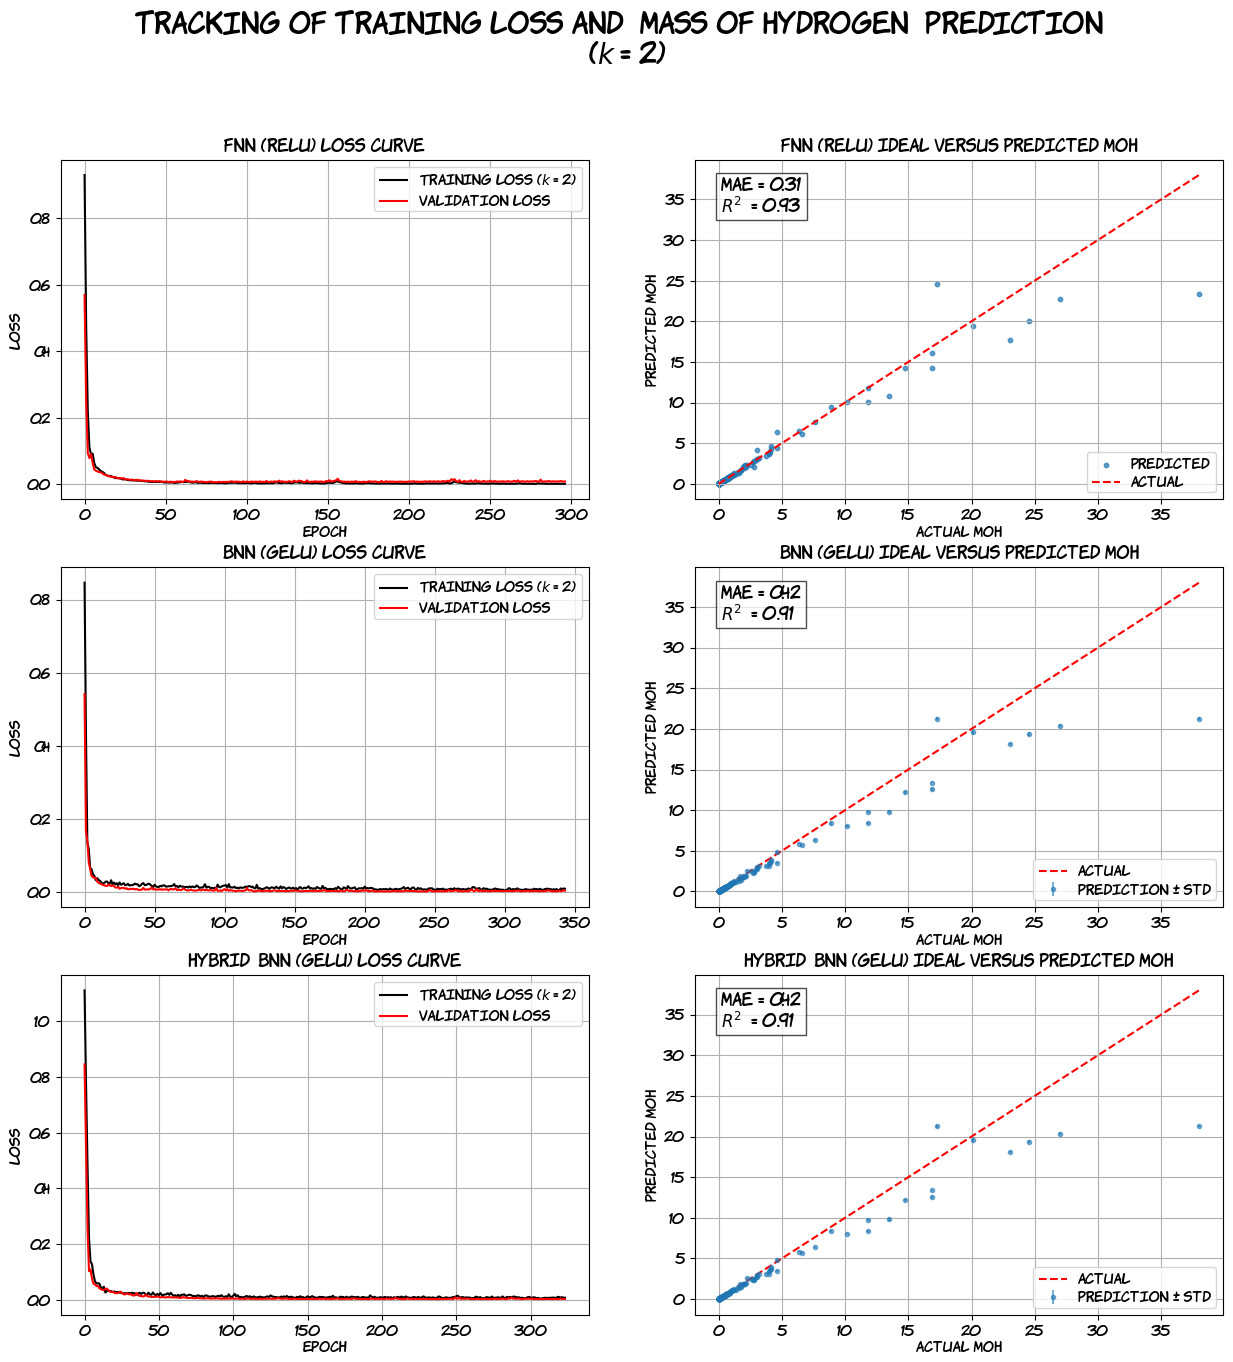

In [8]:
### GRAPHICAL PLOTS FOR IDEAL VERSUS PREDICTED VALUES & TRAINING AND VALIDATION LOSS TRACKING (COMBINED) ###
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "/content/KOMIKAH_.ttf"
fm.fontManager.addfont(font_path)
komika = fm.FontProperties(fname=font_path)

# Set globally
plt.rcParams['font.family'] = komika.get_name()

# Explicitly disable LaTeX rendering
plt.rcParams['text.usetex'] = False


## Defining the selected Neural Network Model and their corresponding Activation Functions ##
models = ['FNN', 'BNN', 'Hybrid-BNN']
activations = {'FNN': 'ReLU', 'BNN': 'GELU', 'Hybrid-BNN': 'GELU'}

## Defining the selected neural network model training & validation losses dictionaries as well as their corresponding activation functions ##
train_losses_dict = {
    'FNN': fnn_train_losses,
    'BNN': bnn_train_losses,
    'Hybrid-BNN': hybrid_train_losses
}

val_losses_dict = {
    'FNN': fnn_val_losses,
    'BNN': bnn_val_losses,
    'Hybrid-BNN': hybrid_val_losses
}

results_dict = {
    'FNN': fnn_results,
    'BNN': bnn_results,
    'Hybrid-BNN': bnn_results
}


## Defining the Graphical Plot Configurations ##
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle("TRACKING OF TRAINING LOSS AND  MASS OF HYDROGEN  PREDICTION \n ($k$ = 2)", fontsize=20)

for idx, model in enumerate(models):
    act = activations[model]


    ## Graphical Plots 1: Training vs Validation Loss ##
    ax1 = axes[idx, 0]
    ax1.plot(train_losses_dict[model][act], label='Training Loss ($k$ = 2)',color='k')
    ax1.plot(val_losses_dict[model][act], label='Validation Loss',color='r')
    ax1.set_title(f'{model} ({act}) Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ## Graphical Plots 2: True vs Predicted MoH ##
    ax2 = axes[idx, 1]
    y_true = results_dict[model][act]['y_true']
    y_pred = results_dict[model][act]['y_pred']

    ## Adding Errors Bars for uncertainty for the Hybrid-BNN ##

    if 'y_std' in results_dict[model][act]:
        y_std = results_dict[model][act]['y_std']
        ax2.errorbar(y_true.flatten(), y_pred.flatten(), yerr=y_std.flatten(), fmt='o', markersize=3, alpha=0.6, label='Prediction ± std')
    else:
        ax2.scatter(y_true, y_pred, s=10, alpha=0.7, label='Predicted')

    ## Diagonal line for the Ideal versus Predicted MoH Graphical Plots ##

    ax2.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Actual')

    ## Annotating the Metrics on the MoH Graphical Plots ##
    mae = results_dict[model][act]['mae']
    r2 = results_dict[model][act]['r2']
    ax2.text(0.05, 0.95,
         (f'MAE = {mae:.2f}\n'
          rf'$R^2$  = {r2:.2f}'),
         transform=ax2.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7))


    ax2.set_title(f'{model} ({act}) Ideal Versus Predicted MoH')
    ax2.set_xlabel('Actual MoH')
    ax2.set_ylabel('Predicted MoH')
    ax2.legend()
    ax2.grid(True)

## Final Layout Adjustments for the Graphical Plots ##
# plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("Model_Comparison_Plots_2.png", dpi=600)
plt.show()

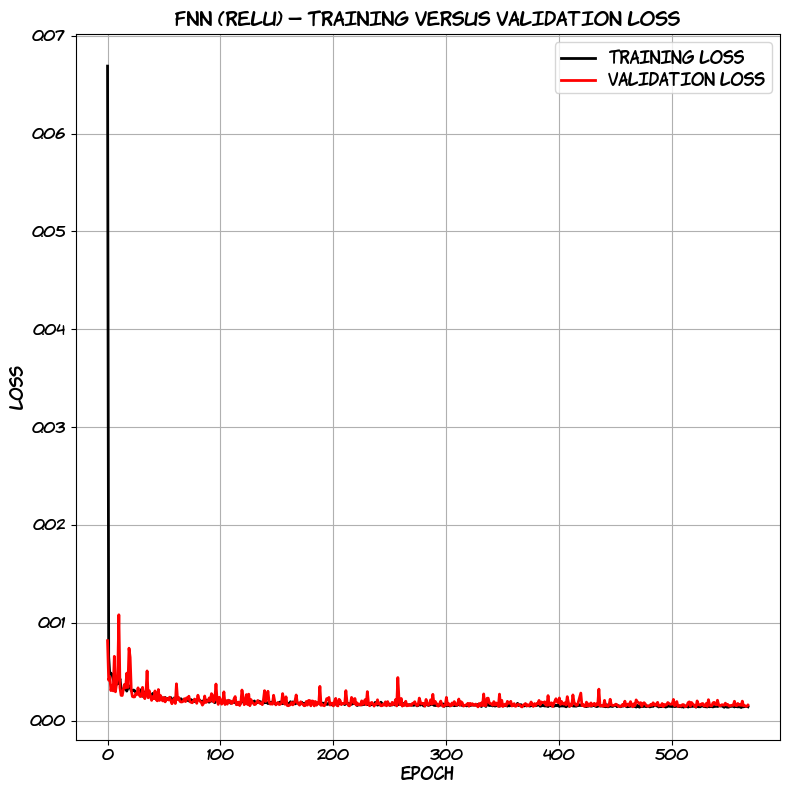

Saved: Individual_Model_Plots/fnn_Loss_Plot.png


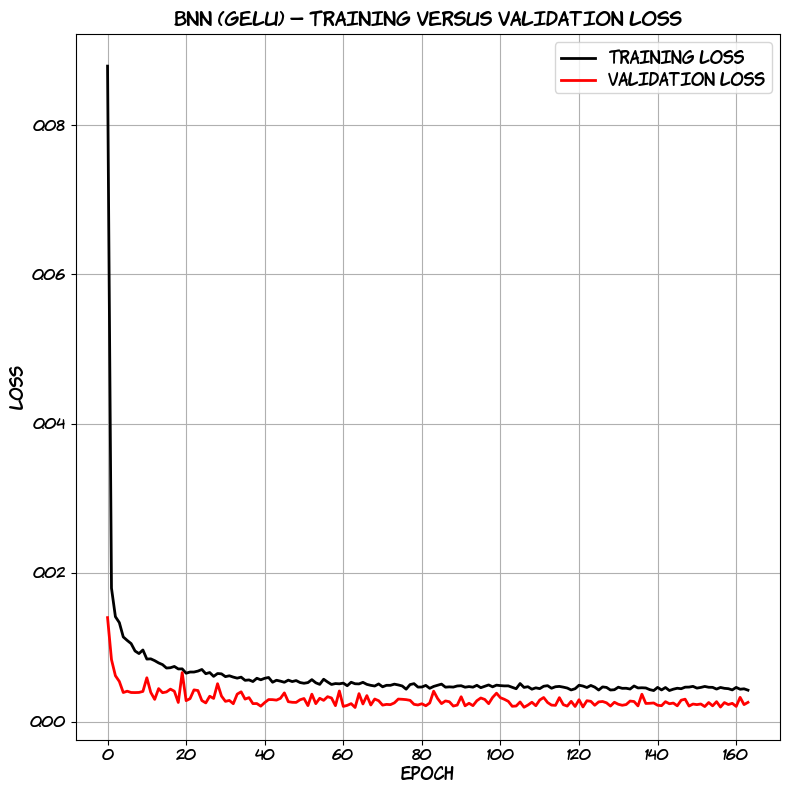

Saved: Individual_Model_Plots/bnn_Loss_Plot.png


/tmp/ipython-input-3885257814.py:23: UserWarning: Glyph 45 (-) missing from font(s) Komika Hand.
  plt.tight_layout()
/tmp/ipython-input-3885257814.py:26: UserWarning: Glyph 45 (-) missing from font(s) Komika Hand.
  plt.savefig(filename, dpi=600)


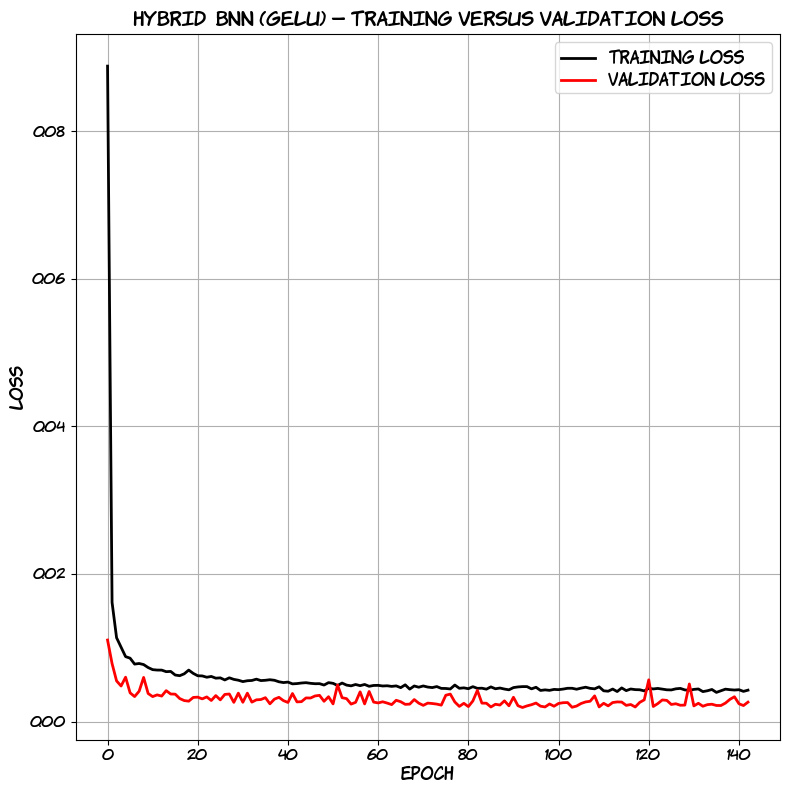

Saved: Individual_Model_Plots/hybrid_bnn_Loss_Plot.png


/tmp/ipython-input-3885257814.py:60: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) Komika Hand.
  plt.tight_layout()
/tmp/ipython-input-3885257814.py:63: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) Komika Hand.
  plt.savefig(filename, dpi=600)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) Komika Hand.
  fig.canvas.print_figure(bytes_io, **kw)


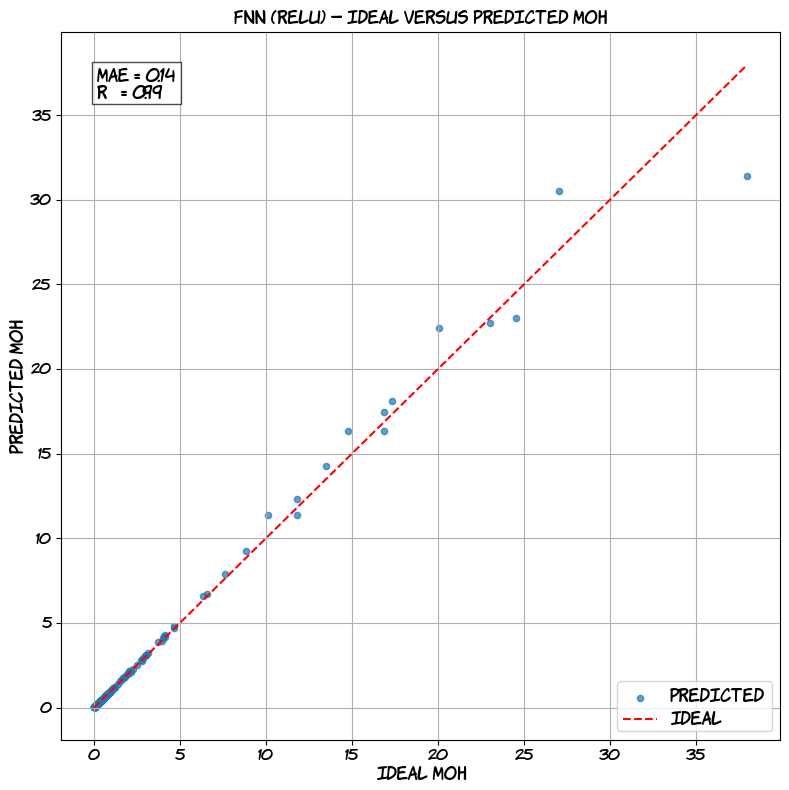

Saved: Individual_Model_Plots/fnn_Prediction_Plot.png


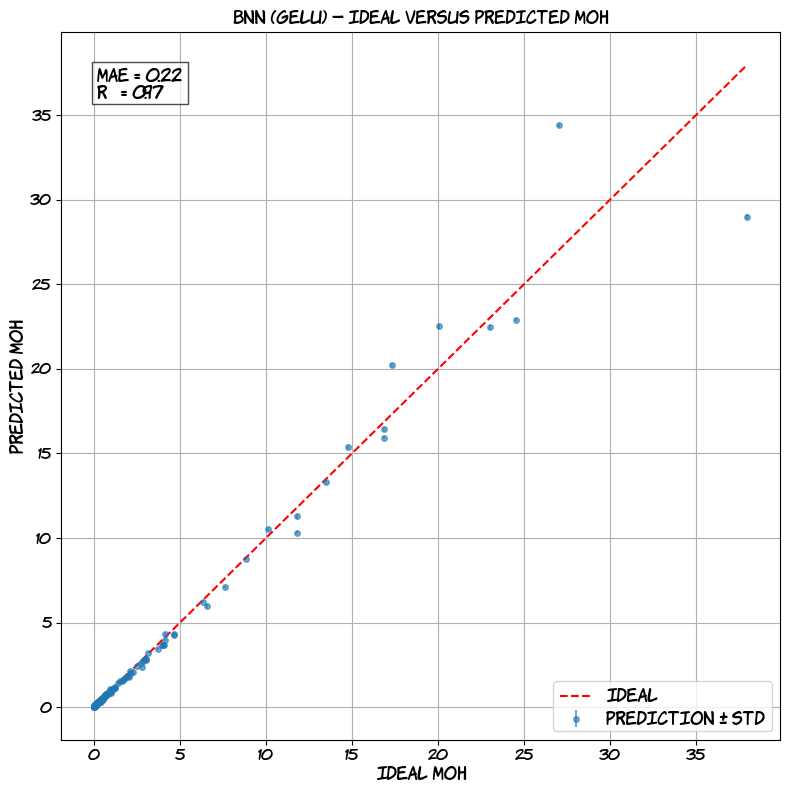

Saved: Individual_Model_Plots/bnn_Prediction_Plot.png


/tmp/ipython-input-3885257814.py:60: UserWarning: Glyph 45 (-) missing from font(s) Komika Hand.
  plt.tight_layout()
/tmp/ipython-input-3885257814.py:63: UserWarning: Glyph 45 (-) missing from font(s) Komika Hand.
  plt.savefig(filename, dpi=600)


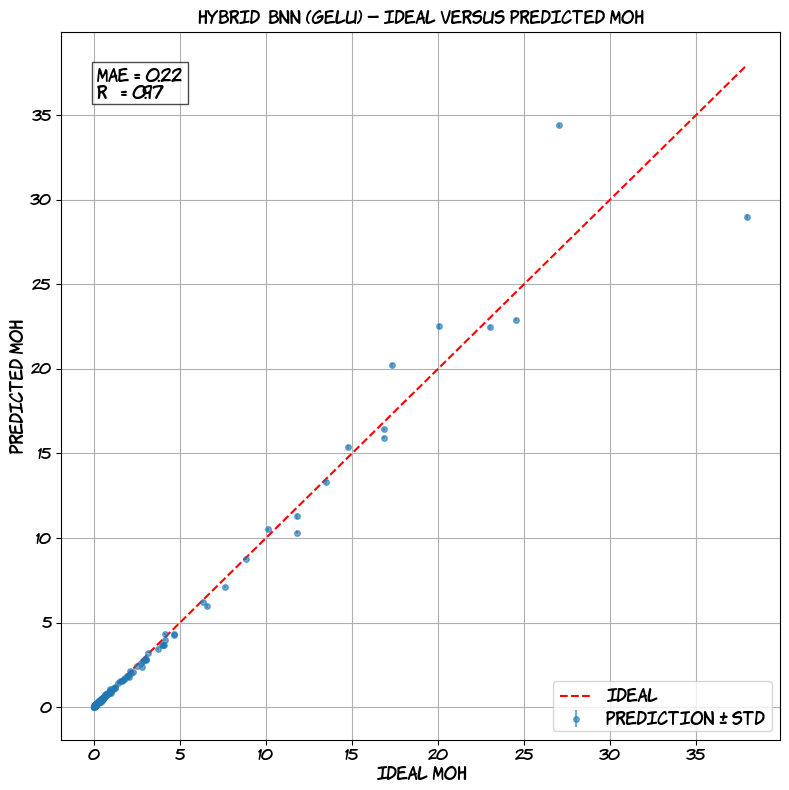

Saved: Individual_Model_Plots/hybrid_bnn_Prediction_Plot.png


In [ ]:
### GRAPHICAL PLOTS FOR IDEAL VERSUS PREDICTED VALUES & TRAINING AND VALIDATION LOSS TRACKING (INDIVIDUAL) ###

## Creating a Directory doe Saving the Graphical Plots ##
os.makedirs("Individual_Model_Plots", exist_ok=True)

## Defining the Models and Activation Mappings  ##
models = ['FNN', 'BNN', 'Hybrid-BNN']
activations = {'FNN': 'ReLU', 'BNN': 'GELU', 'Hybrid-BNN': 'GELU'}


## Defining the Training and Validation Loss Plots  ##
for model in models:
    act = activations[model]

    plt.figure(figsize=(8, 8))
    plt.plot(train_losses_dict[model][act], label="Training Loss", linewidth=2, color='k')
    plt.plot(val_losses_dict[model][act], label="Validation Loss", linewidth=2, color='r')
    plt.title(f"{model} ({act}) — Training Versus Validation Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    filename = f"Individual_Model_Plots/{model.lower().replace('-', '_')}_Loss_Plot.png"
    plt.savefig(filename, dpi=600)
    plt.show()
    print(f"Saved: {filename}")

## Defining the Graphical Plots for each model:True Versus Predicted MoH Plots  ##
for model in models:
    act = activations[model]
    y_true = results_dict[model][act]["y_true"]
    y_pred = results_dict[model][act]["y_pred"]

    plt.figure(figsize=(8, 8))

    if "y_std" in results_dict[model][act]:
        y_std = results_dict[model][act]["y_std"]
        plt.errorbar(y_true.flatten(), y_pred.flatten(), yerr=y_std.flatten(),
                     fmt='o', markersize=4, alpha=0.6, label="Prediction ± std")
    else:
        plt.scatter(y_true, y_pred, s=20, alpha=0.7, label="Predicted")

     ## Plotting the Reference Line ##
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', label="Ideal")

    ## Annotating the Metrics ##
    mae = results_dict[model][act]["mae"]
    r2 = results_dict[model][act]["r2"]
    plt.text(0.05, 0.95, f"MAE = {mae:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

    plt.title(f"{model} ({act}) — Ideal Versus Predicted MoH", fontsize=12)
    plt.xlabel("Ideal MoH", fontsize=12)
    plt.ylabel("Predicted MoH", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    filename = f"Individual_Model_Plots/{model.lower().replace('-', '_')}_Prediction_Plot.png"
    plt.savefig(filename, dpi=600)
    plt.show()
    print(f"Saved: {filename}")

In [ ]:
### INDIVIDUAL GRAPHICAL PLOTS ###
y_true = y_test_raw.flatten()
y_pred_fnn = fnn_results['ReLU']['y_pred'].flatten()
y_pred_bnn = bnn_results['GELU']['y_pred'].flatten()
y_pred_hybrid = hybrid_results['GELU']['y_pred'].flatten()

## Defining Plotting Function with the metrics ##
def plot_pred_vs_true(y_true, y_pred, model_name, color='blue'):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    plt.figure(figsize=(8,8))
    plt.scatter(y_true, y_pred, color=color, alpha=0.8, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual MoH (g)')
    plt.ylabel('Predicted MoH (g)')
    plt.title(f'{model_name} — R²={r2:.3f}, RMSE={rmse:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('HYBRID_BNN_PLOT_MOH', dpi=600)
    plt.show()
## Graphical Plots for Each Model ##
# plot_pred_vs_true(y_true, y_pred_fnn, "FNN", color='dodgerblue')
# plot_pred_vs_true(y_true, y_pred_bnn, "BNN", color='seagreen')
# plot_pred_vs_true(y_true, y_pred_hybrid, "HybridBNN", color='darkorange')

In [ ]:
## Defining the Function for the Ideal Versus True VoH ##
def plot_voh_predictions(y_true, y_pred, title, color='blue'):
    plt.figure(figsize=(8,8))
    plt.scatter(y_true, y_pred, color=color, alpha=0.6, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Ideal VoH (L)")
    plt.ylabel("Predicted VoH (L)")
    plt.title(title)
    plt.grid(True)
    plt.savefig('FNN_PLOT_VOH', dpi=600)
    plt.show()

## Graphical Plots for each model in additon to their best configurations: Ideal Versus True VoH ##
# plot_voh_predictions(y_test_voh, voh_pred_fnn_relu, "FNN (RELU) — MoH → VoH", color='dodgerblue')
# plot_voh_predictions(y_test_voh, voh_pred_bnn_gelu, "BNN(GELU) — MoH → VoH", color='seagreen')
# plot_voh_predictions(y_test_voh, voh_pred_hybrid_gelu, "HybridBNN (GELU) — MoH → VoH", color='darkorange')